# Test dev shift fit

on signle distribution for all months, and different model for each month

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, 
# statsmodels, seaborn

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4

%matplotlib inline

#plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import my variables settings functions from other scripts
from settings import *
from functions import *
from utils import *
from plotscript import *

# import other packages/modules 

sys.path.append('../population/') # make this a module i can pip install and import ! 
from population_demographics_climate import * # move / rename this when good ! --> change to import demographics4climate as d4c


/apps/brussel/CO7/broadwell/software/Python/3.10.4-GCCcore-11.3.0/lib/python3.10/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
/apps/brussel/RL8/broadwell/software/statsmodels/0.13.1-foss-2022a/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
from scipy import stats
import seaborn as sns

import corner # installed in myenv

from statsmodels.nonparametric.smoothers_lowess import lowess


#import dist_cov # env = myenv where i installed dist_cov

sys.path.append('../dist_cov/dist_cov/')
import distributions as distributions
import sample as sample
import utils as utils 

In [3]:
start_message() 

flags: {'models': 'ISIMIP3a', 'experiment': 'obsclim', 'metric': 'WBGT', 'method': 'shift_fit', 'time_method': None, 'chunk_version': 0, 'var': 'wbgt'}
var: wbgt
VARs: None
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir_obs: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/obsclim/global/daily/historical/
indir_counterclim: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/counterclim/global/daily/historical/
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']
datasets: ['GSWP3-W5E5', '20CRv3', '20CRv3-ERA5', '20CRv3-W5E5']
lat_chunk: 90
lon_chunk: 120
time_chunk: -1
outdirs: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output
figdirs: /data/brussel/vo/000/bvo00

In [4]:
figdir = os.path.join(figdirs, 'fig_apr24-isimip3a-wbgt')
flags['models'] = 'ISIMIP3a'
GCM=datasets[0]  # 'GSWP3-W5E5'

## Open gmst data

In [5]:
# open gmst
# annual obs warming
df_gmst_obs_annual = pd.read_csv(os.path.join('../../data/gmst/gmst-obs/forster2023/annual_averages.csv')).rename(
    columns={'timebound_lower':'year'}).set_index('year')[['gmst']]
df_gmst_obs_annual

gmst
year          
1850 -0.053137
1851  0.056863
1852  0.084363
1853  0.049363
1854  0.049363
...        ...
2018  1.109363
2019  1.236863
2020  1.269363
2021  1.109363
2022  1.154363

[173 rows x 1 columns]

<AxesSubplot:xlabel='year'>

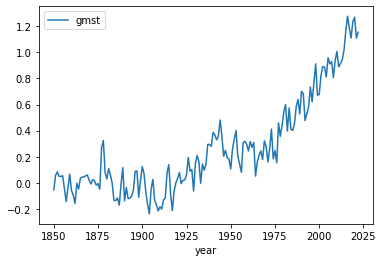

In [6]:
df_gmst_obs_annual.plot()

# spike in 1877: https://www.climate-lab-book.ac.uk/2016/spiralling-global-temperatures/

In [7]:
def apply_lowess(y, x=None, ntime=31):
    ''' y should be an xarray DataArray,
        x is used when provided, else falling back to standard indices
    '''
    # Squeeze (in case there is a dimension of size 1 that we don't need)
    y = y.squeeze()
    
    # Create a copy, plug in smoothed data later
    final = y.copy(deep=True)
    
    if x is None:
        x = np.arange(y.size)
    
    if not isinstance(y, np.ndarray):
        y = y.values

    # Apply LOWESS smoothing
    result = lowess(y, x, frac=ntime/y.size)
    
    x_smooth, y_smooth = result[:, 0], result[:, 1]
    
    # Ensure the smoothed result has the same length as the original data
    y_smooth_full = np.interp(x, x_smooth, y_smooth)

    # Assign the smoothed values back to the xarray DataArray
    final[:] = y_smooth_full[:]

    return final

# Example usage with your data
# gmst_ts = xr.DataArray(...)  # Load your DataArray
# smoothed_data = apply_lowess(gmst_ts.Ta, ntime=15*12)

In [8]:
gmst_smo = pd.DataFrame(apply_lowess(df_gmst_obs_annual, df_gmst_obs_annual.index, ntime=4))
gmst_smo

gmst
year          
1850 -0.043519
1851  0.032947
1852  0.066480
1853  0.059362
1854  0.050768
...        ...
2018  1.176428
2019  1.212890
2020  1.212564
2021  1.172323
2022  1.135193

[173 rows x 1 columns]

<AxesSubplot:xlabel='year'>

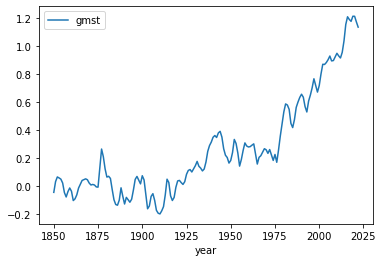

In [9]:
gmst_smo.plot() # 4-year lowess smooothing 

## Open data: one pixel for Delhi and one pixel for Calcutta

In [10]:
variable='wbgt'
dirname='output_apr24-9139513' #'output_apr24-9110516' - put them in same folder!
dir1=os.path.join(scratchdirs, dirname, 'WBGT', flags['models'], 'obsclim', GCM ) # if you always change flags metric you can also replace with fxn 
filepaths=get_filepaths(variable.upper(),dir1)


In [11]:
with xr.open_mfdataset(filepaths, engine='netcdf4') as ds:
    lat, lon = 28,77
    da_delhi = ds[str(variable)].sel(lat=lat, lon=lon, method='nearest').chunk({'time': -1}).compute()
    lat, lon = 22,88
    da_calcutta = ds[str(variable)].sel(lat=lat, lon=lon, method='nearest').chunk({'time': -1}).compute()

In [12]:
# save for train

#df_gmst_obs_annual.to_csv('_temp_fortrain/df_gmst_obs_annual.csv')
#da_delhi.to_netcdf('_temp_fortrain/da_delhi_wbgt.nc')
#da_calcutta.to_netcdf('_temp_fortrain/da_calcutta_wbgt.nc')


In [13]:
da_delhi

<xarray.DataArray 'wbgt' (time: 43464)>
array([16.66319 , 16.832773, 16.74808 , ..., 13.003847, 11.634802,
       12.386272], dtype=float32)
Coordinates:
    lon      float32 77.25
    lat      float32 28.25
  * time     (time) datetime64[ns] 1901-01-01 1901-01-02 ... 2019-12-31

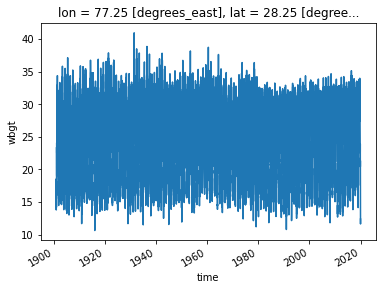

In [14]:
da_delhi.plot()

# variance changes first and second datasets that are merged
# match variance of first half to variance of second somehow? 

In [15]:
da_sel = da_delhi.sel(time=slice('1900-01-01','1978-12-31'))

print('mean, std, annual range mean, annual range standard deviation of gswp3')

da_sel.mean().values, da_sel.std().values, (da_sel.groupby("time.year").max() - da_sel.groupby("time.year").min()).mean().values , (da_sel.groupby("time.year").max() - da_sel.groupby("time.year").min()).std().values

# mean and standard deviation

mean, std, annual range mean, annual range standard deviation of gswp3


(array(25.211151, dtype=float32),
 array(5.33595514),
 array(21.28871089),
 array(2.10347853))

In [16]:
da_sel = da_delhi.sel(time=slice('1978-01-01','2019-12-31'))

print('mean, std, annual range mean, annual range standard deviation of w5e5')

da_sel.mean().values, da_sel.std().values, (da_sel.groupby("time.year").max() - da_sel.groupby("time.year").min()).mean().values, (da_sel.groupby("time.year").max() - da_sel.groupby("time.year").min()).std().values

# mean incrases, std decreases, yearly range decreases, variance in yearly range decreases 

mean, std, annual range mean, annual range standard deviation of w5e5


(array(25.355621, dtype=float32),
 array(5.25520754),
 array(19.95892675),
 array(1.52288729))

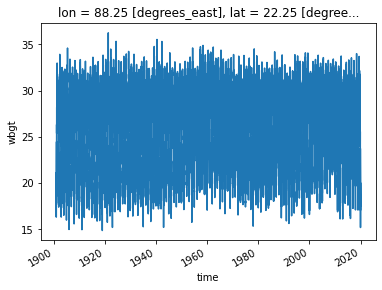

In [17]:
da_calcutta.plot()

In [18]:
da_sel = da_calcutta.sel(time=slice('1900-01-01','1978-12-31'))

print('mean, std, annual range mean, annual range standard deviation')

da_sel.mean().values, da_sel.std().values, (da_sel.groupby("time.year").max() - da_sel.groupby("time.year").min()).mean().values , (da_sel.groupby("time.year").max() - da_sel.groupby("time.year").min()).std().values


mean, std, annual range mean, annual range standard deviation


(array(26.55276, dtype=float32),
 array(3.93901181),
 array(16.27131071),
 array(1.44929234))

In [19]:
da_sel = da_calcutta.sel(time=slice('1978-01-01','2019-12-31'))

print('mean, std, annual range mean, annual range standard deviation')

da_sel.mean().values, da_sel.std().values, (da_sel.groupby("time.year").max() - da_sel.groupby("time.year").min()).mean().values, (da_sel.groupby("time.year").max() - da_sel.groupby("time.year").min()).std().values

# incr mean, decr std, range decr, range variance decr 

mean, std, annual range mean, annual range standard deviation


(array(27.163345, dtype=float32),
 array(3.72601342),
 array(15.80099846),
 array(1.27552591))

## ideas 

in these places between gswp3 and w5e5 mean increases, std decreases, yearly range decreases and variance in range decreases. 

Idea: check if there is a systmatic decrease in annual range of tempreatures and in the std of this between the old and new dataset (pre and post 1979), which might be due to bias in dataset and could introduce spurious trend in variability 

# option 1. don't deseasonalize data, fit a non stationary model to each month

To estimate change in the probability of exceeding 28 deg for different values of GMST (e.g. GMST of today and GMST - human induced warming e.g. through current GWI 1.3 or whatever it was in 2022 my baseline year)

To do :
- calc goodness of fit (e.g. AIC, or other metrics) to understand impact of not deseasonalizing and compare goodness of fit of different models! (incl. considering fixed or varying scale and full year distribution versus per month) 
- decide definition of present-day versus pre-industrial based on gmst 

## how is monthly distribution changing?

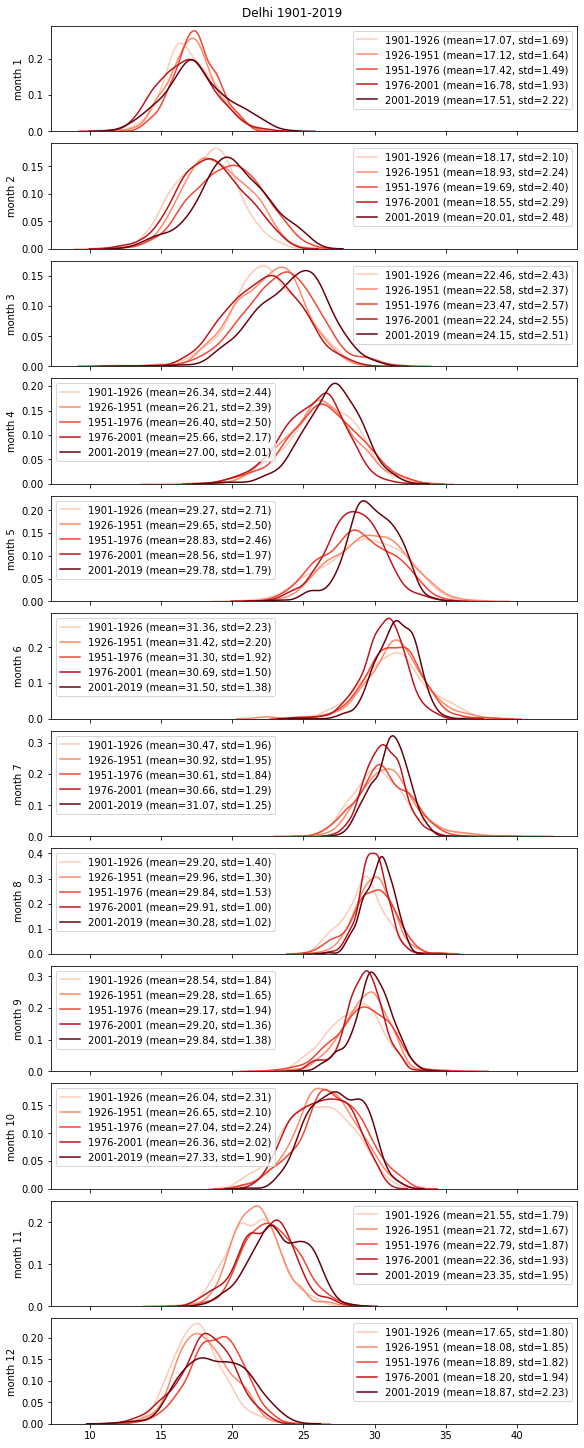

In [20]:
# see how monthly distribution shifting - Delhi

fig, axes = plt.subplots(12,1,figsize=(8,20),layout='constrained', sharex=True)

win=25

# Create a colormap
cmap = plt.get_cmap('Reds')
colors = cmap(np.linspace(0, 1, len(np.unique(da_delhi.time.dt.year)) // win +2))[1:]


# loop over months 
for j in range(1,13):
    startyear = 1901 
    ax=axes[j-1]
    
    
    for i in range(len(np.unique(da_delhi.time.dt.year)) // win + 1):
        data_plot = da_delhi.sel(time=slice(f'{startyear}-01-01', f'{startyear+win}-01-01'))
        data_plot = data_plot.sel(time=data_plot['time.month'].isin([j]))
        endyear = min(startyear+win, 2019)
        sns.kdeplot(data_plot.values, label=f'{startyear}-{endyear} (mean={data_plot.mean():.2f}, std={data_plot.std():.2f})', ax=ax, color=colors[i]);
        startyear+=win
    
    ax.legend()
    ax.set_ylabel(f'month {j}')
    
fig.suptitle('Delhi 1901-2019');

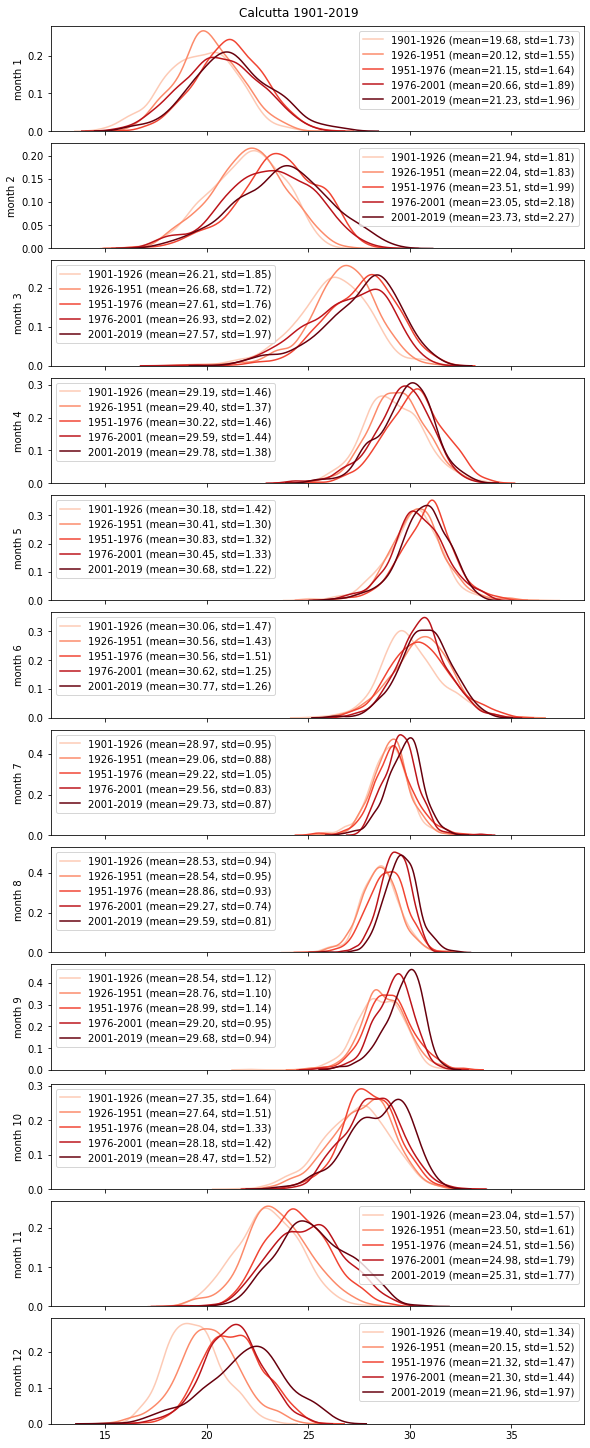

In [21]:
# monthly distribution shifting - Calcutta

fig, axes = plt.subplots(12,1,figsize=(8,20),layout='constrained', sharex=True)

win=25

# Create a colormap
cmap = plt.get_cmap('Reds')
colors = cmap(np.linspace(0, 1, len(np.unique(da_calcutta.time.dt.year)) // win +2))[1:]


# loop over months 
for j in range(1,13):
    startyear = 1901 
    ax=axes[j-1]
    
    
    for i in range(len(np.unique(da_calcutta.time.dt.year)) // win + 1):
        data_plot = da_calcutta.sel(time=slice(f'{startyear}-01-01', f'{startyear+win}-01-01'))
        data_plot = data_plot.sel(time=data_plot['time.month'].isin([j]))
        endyear = min(startyear+win, 2019)
        sns.kdeplot(data_plot.values, label=f'{startyear}-{endyear} (mean={data_plot.mean():.2f}, std={data_plot.std():.2f})', ax=ax, color=colors[i]);
        startyear+=win
    
    ax.legend()
    ax.set_ylabel(f'month {j}')
    
fig.suptitle('Calcutta 1901-2019');

## fit distcov on Delhi data : version 1. only loc changes

### a) one annual model 

In [22]:
da_delhi

<xarray.DataArray 'wbgt' (time: 43464)>
array([16.66319 , 16.832773, 16.74808 , ..., 13.003847, 11.634802,
       12.386272], dtype=float32)
Coordinates:
    lon      float32 77.25
    lat      float32 28.25
  * time     (time) datetime64[ns] 1901-01-01 1901-01-02 ... 2019-12-31

In [23]:
gmst_smo

gmst
year          
1850 -0.043519
1851  0.032947
1852  0.066480
1853  0.059362
1854  0.050768
...        ...
2018  1.176428
2019  1.212890
2020  1.212564
2021  1.172323
2022  1.135193

[173 rows x 1 columns]

In [24]:
x = da_delhi.values
x

array([16.66319 , 16.832773, 16.74808 , ..., 13.003847, 11.634802,
       12.386272], dtype=float32)

In [25]:
t = da_delhi.time.dt.year
t

<xarray.DataArray 'year' (time: 43464)>
array([1901, 1901, 1901, ..., 2019, 2019, 2019])
Coordinates:
    lon      float32 77.25
    lat      float32 28.25
  * time     (time) datetime64[ns] 1901-01-01 1901-01-02 ... 2019-12-31

In [26]:
cov = gmst_smo.loc[t.values].values.squeeze()
cov

# covariate is gmst value corresponding to each year

array([0.0456877 , 0.0456877 , 0.0456877 , ..., 1.21288951, 1.21288951,
       1.21288951])

In [27]:
dist = distributions.norm_cov(data=x, cov=cov)


In [28]:
params_mle = dist.fit()

print(dist.param_names)
print(np.round(params_mle, 3))

['b0', 'b1', 'sigma']
[24.987  0.755  5.297]


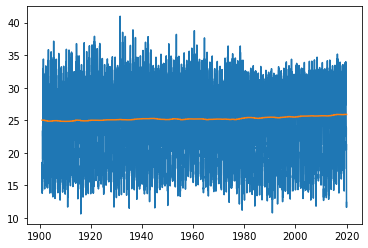

In [29]:
predicted = dist.predict(params_mle, cov)

# ===

f, ax = plt.subplots()

ax.plot(da_delhi.time, x)

ax.plot(da_delhi.time, predicted)

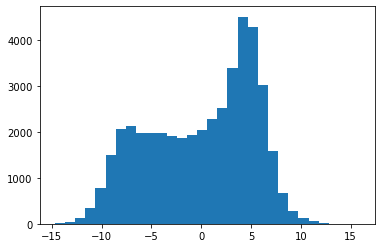

In [30]:
residuals = x - predicted
plt.hist(residuals,bins=30); # not normal at all 

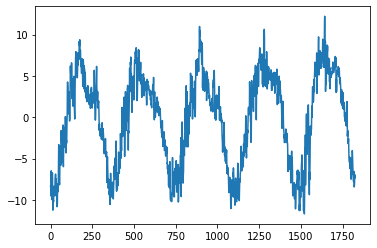

In [31]:
plt.plot(residuals[0:365*5 ]) # not normal, clear seasonality 

In [32]:
b0, b1, sigma = params_mle

In [33]:
float(df_gmst_obs_annual.loc[2022]), float(gmst_smo.loc[2022])

(1.154362745, 1.1351930101127619)

In [34]:
from scipy.stats import norm

gmst_pres = float(gmst_smo.loc[2022])
gmst_pi = float(gmst_pres - 1.3)

norm_pi, norm_pres = norm(loc=b0+b1*gmst_pi, scale=sigma), norm(loc=b0+b1*gmst_pres, scale=sigma)

In [35]:
print(norm_pi.kwds['loc'], norm_pres.kwds['loc'], norm_pres.kwds['scale'])

24.863074088071276 25.844497685372154 5.297099667235522


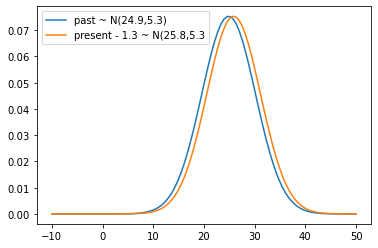

In [36]:
xi = np.linspace (-10,50,100)

plt.plot(xi, norm_pi.pdf(xi), label=f"past ~ N({norm_pi.kwds['loc']:.1f},{norm_pres.kwds['scale']:.1f})")
plt.plot(xi, norm_pres.pdf(xi), label=f"present - 1.3 ~ N({norm_pres.kwds['loc']:.1f},{norm_pres.kwds['scale']:.1f}")

plt.legend()

In [37]:
threshold = 28
PR = norm_pres.sf(threshold)/norm_pi.sf(threshold) 
PR

1.2354030533506064

In [38]:
(norm_pres.sf(threshold) - norm_pi.sf(threshold) ) * 365 

# additional days 
# ~ 24 extra days per year 

23.78834318822062

### b) one model per month mu shift fit, scale constant

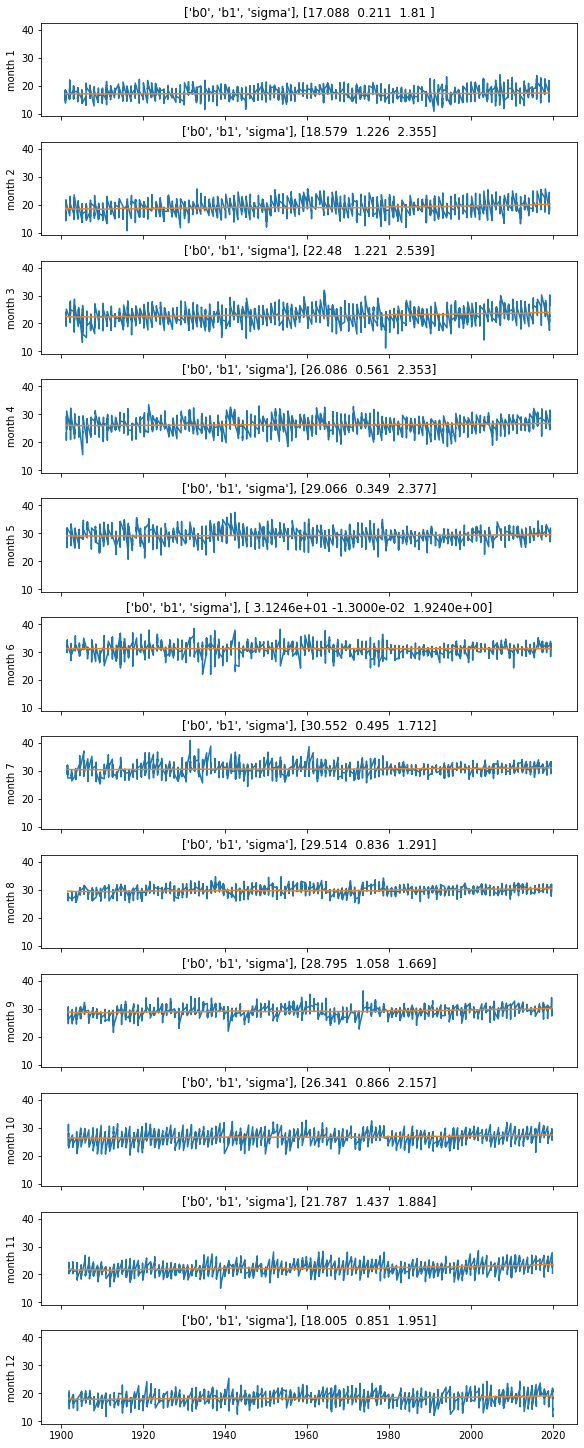

In [39]:
# monthly distribution shifting

fig, axes = plt.subplots(12,1,figsize=(8,20),layout='constrained', sharex=True, sharey=True)

arr_params = []

# loop over months 
for j in range(1,13):
    ax=axes[j-1]
    
    da = da_delhi.sel(time=da_delhi['time.month'].isin([j]))
    x = da.values
    t = da.time.dt.year 
    cov = gmst_smo.loc[t.values].values.squeeze()
    
    dist = distributions.norm_cov(data=x, cov=cov)
    params_mle = dist.fit()
    predicted = dist.predict(params_mle, cov)

    ax.plot(da.time, x)
    ax.plot(da.time, predicted)
    
    ax.set_title(f'{dist.param_names}, {np.round(params_mle, 3)}')
    ax.set_ylabel(f'month {j}')
    
    arr_params.append(params_mle)
    
arr_params = np.array(arr_params)

In [40]:
arr_params

array([[ 1.70882863e+01,  2.10760030e-01,  1.80954773e+00],
       [ 1.85787287e+01,  1.22614949e+00,  2.35512045e+00],
       [ 2.24800340e+01,  1.22080562e+00,  2.53907429e+00],
       [ 2.60857144e+01,  5.60668601e-01,  2.35275603e+00],
       [ 2.90662827e+01,  3.48502920e-01,  2.37714533e+00],
       [ 3.12459334e+01, -1.29661167e-02,  1.92404311e+00],
       [ 3.05520883e+01,  4.95361025e-01,  1.71207578e+00],
       [ 2.95138376e+01,  8.35784742e-01,  1.29064682e+00],
       [ 2.87951698e+01,  1.05759411e+00,  1.66855712e+00],
       [ 2.63407130e+01,  8.66467340e-01,  2.15683036e+00],
       [ 2.17866981e+01,  1.43678808e+00,  1.88400732e+00],
       [ 1.80051594e+01,  8.51489406e-01,  1.95125362e+00]])

#### check residuals for goodness of fit

Check normality of residuals to assess goodness of fit (also possibly see if there is still some seasonality/temporal trend in resduals)

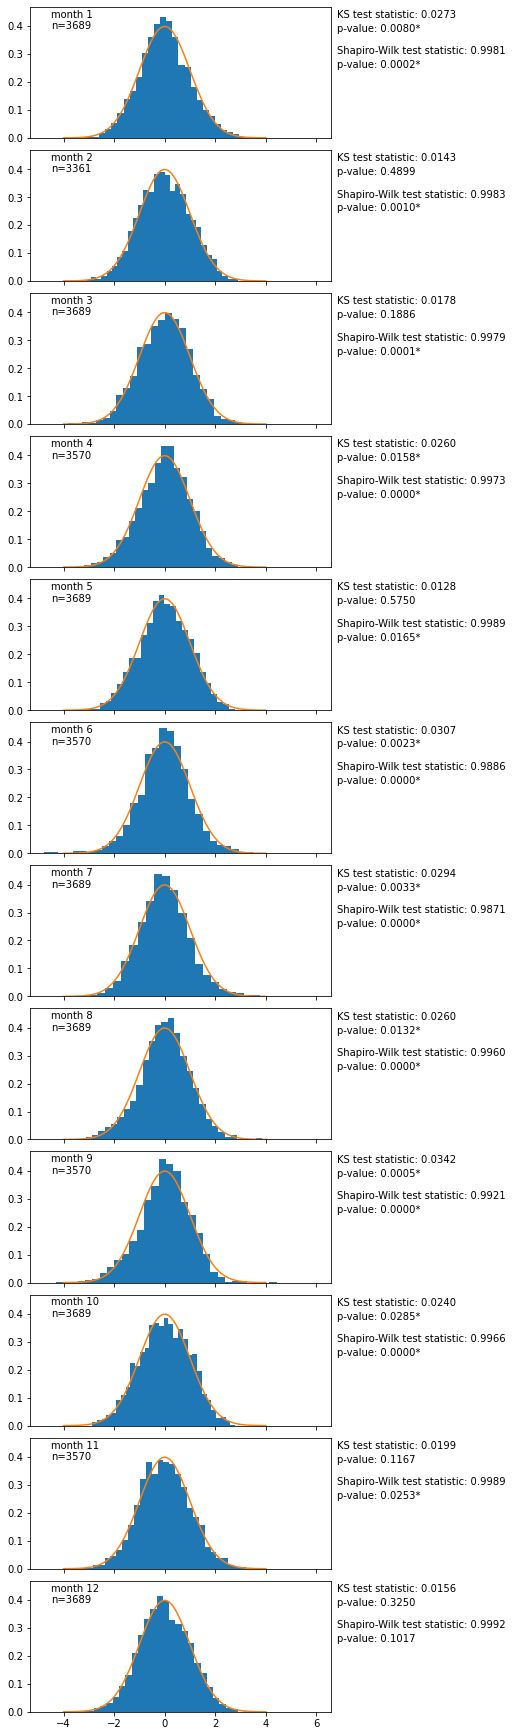

In [41]:
# check residuals 
from scipy.stats import norm, kstest, anderson, shapiro

# do i need to standardize them to do these tests?


fig, axes = plt.subplots(12,1,figsize=(7,24),layout='constrained', sharex=True, sharey=True) # figsize 5, 30 for non standardized residuals 

norm_standard = norm(loc=0, scale=1)

# loop over months 
for j in range(1,13):
    ax=axes[j-1]
    
    da = da_delhi.sel(time=da_delhi['time.month'].isin([j]))
    x = da.values
    t = da.time.dt.year 
    cov = gmst_smo.loc[t.values].values.squeeze()
    
    dist = distributions.norm_cov(data=x, cov=cov)
    params_mle = dist.fit()
    predicted = dist.predict(params_mle, cov)
    
    residuals = x - predicted
    
    # plot raw residuals
    #ax.hist(residuals,bins=30,density=True); 
    
    # plot standardixed residuals 
    standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
    ax.hist(standardized_residuals,bins=30,density=True); # not normal at all 
    
    # plot theoretical distr
    xi=np.linspace(-4,4,100)
    ax.plot(xi,norm_standard.pdf(xi))
    
    ax.text(-4.5,0.39,f'month {j}\nn={len(standardized_residuals)}')

    
    # Kolmogorov-Smirnov Test: test 
    # H0: standard normal, Ha: not standard normal (p-value < significance)
    D, p_value = kstest(standardized_residuals, 'norm')
    ax.text(6.8,0.43,f"KS test statistic: {D:.4f}")  # -12,0.3 for non standardized
    if p_value < 0.05:
        ax.text(6.8,0.38,f"p-value: {p_value:.4f}*") # not normally distributed
    else:
        ax.text(6.8,0.38,f"p-value: {p_value:.4f}") # -12,0.25 for non standardized 

    # # Anderson-Darling Test:
    # result = anderson(standardized_residuals, dist='norm')
    # print(f"Statistic: {result.statistic}")
    # for i in range(len(result.critical_values)):
    #     sl, cv = result.significance_level[i], result.critical_values[i]
    #     print(f"Significance level {sl}: {cv}")
        
    #Shapiro-Wilk
    stat, p_value = shapiro(standardized_residuals)

    pos = 0.30
    ax.text(6.8,pos,f"Shapiro-Wilk test statistic: {stat:.4f}")  # -12,0.3 for non standardized
    if p_value < 0.05:
        ax.text(6.8,pos-.05,f"p-value: {p_value:.4f}*") # not normally distributed
    else:
        ax.text(6.8,pos-.05,f"p-value: {p_value:.4f}") # -12,0.25 for non standardized 

# generally look normal, some deviations 
# large sample size gives power to statistical test so you get pval<0.05 just because sample size is so large
# test statistics are close to 0 (KS) or 1 (SW) which indicates similarity with theoretical distr

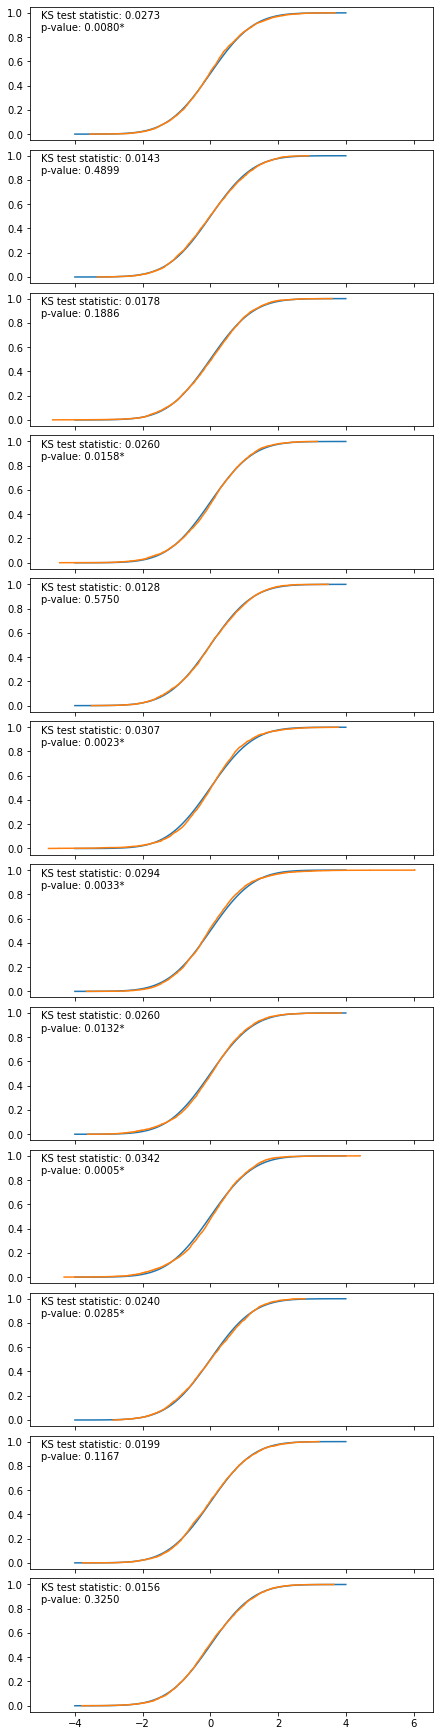

In [42]:
from statsmodels.distributions.empirical_distribution import ECDF

fig, axes = plt.subplots(12,1,figsize=(6,24),layout='constrained', sharex=True, sharey=True) 

norm_standard = norm(loc=0, scale=1)

# loop over months 
for j in range(1,13):
    ax=axes[j-1]
    
    da = da_delhi.sel(time=da_delhi['time.month'].isin([j]))
    x = da.values
    t = da.time.dt.year 
    cov = gmst_smo.loc[t.values].values.squeeze()
    
    dist = distributions.norm_cov(data=x, cov=cov)
    params_mle = dist.fit()
    predicted = dist.predict(params_mle, cov)
    
    residuals = x - predicted
    
    # plot standardixed residuals 
    standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
    
    # plot theoretical distr
    xi=np.linspace(-4,4,100)
    ax.plot(xi,norm_standard.cdf(xi))
    
    # Calculate the ECDF
    #ecdf = ECDF(standardized_residuals)
    # Plot the ECDF
    #ax.step(ecdf.x, ecdf.y, where='post', label='Empirical CDF')
    
    # Sort the data
    sorted_data = np.sort(standardized_residuals)
    # Calculate the ECDF values
    ecdf_values = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    # Plot the ECDF
    ax.step(sorted_data, ecdf_values, where='post', label='Empirical CDF')


    # KS test H0: standard normal, Ha: not standard normal (p-value < significance)
    D, p_value = kstest(standardized_residuals, 'norm')
    ax.text(-5,.95,f"KS test statistic: {D:.4f}")  
    if p_value < 0.05:
        ax.text(-5,.85,f"p-value: {p_value:.4f}*") # not normally distributed
    else:
        ax.text(-5,.85,f"p-value: {p_value:.4f}") 

        # also look very similar 

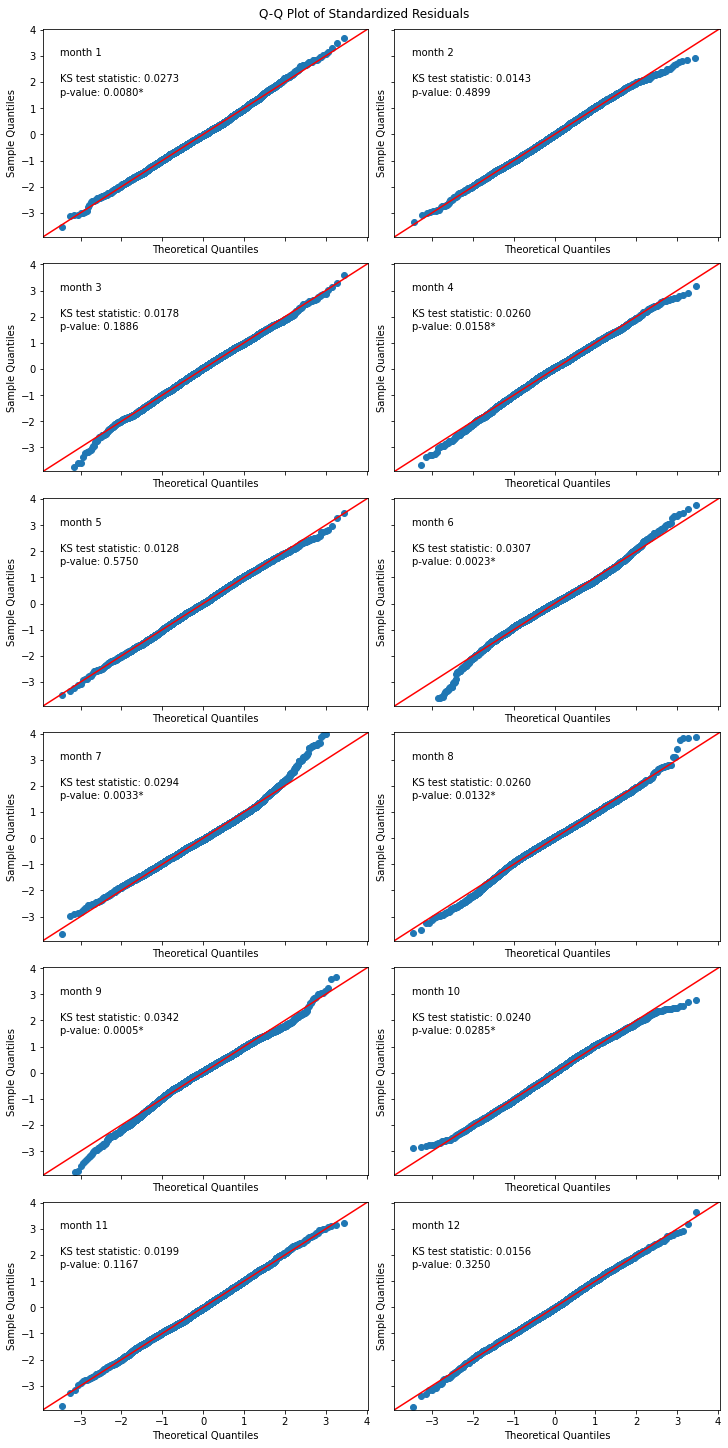

In [43]:
fig, axes = plt.subplots(6,2,figsize=(10,20),layout='constrained', sharex=True, sharey=True) 


# loop over months 
for j in range(1,13):
    ax=axes.flatten()[j-1]
    
    da = da_delhi.sel(time=da_delhi['time.month'].isin([j]))
    x = da.values
    t = da.time.dt.year 
    cov = gmst_smo.loc[t.values].values.squeeze()
    
    dist = distributions.norm_cov(data=x, cov=cov)
    params_mle = dist.fit()
    predicted = dist.predict(params_mle, cov)
    
    residuals = x - predicted
    
    # plot standardixed residuals 
    standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
    
    # Q-Q Plot
    sm.qqplot(standardized_residuals, line ='45',ax=ax)
    ax.text(-3.5,3,f'month {j}')
    
    # KS test H0: standard normal, Ha: not standard normal (p-value < significance)
    D, p_value = kstest(standardized_residuals, 'norm')
    ax.text(-3.5,2,f"KS test statistic: {D:.4f}")  
    if p_value < 0.05:
        ax.text(-3.5,1.5,f"p-value: {p_value:.4f}*") # not normally distributed
    else:
        ax.text(-3.5,1.5,f"p-value: {p_value:.4f}") 

fig.suptitle("Q-Q Plot of Standardized Residuals");

# month 10 has less extreme values than you would expect from normal distr (light tailed)
# month 6 a bit heavy tailed (and concentrated values around mean)
# month 7 right skew
# month 8 outliers in high vals 
# month 2 light tail in high vals
#month 9 heavy tails

# but overall ok fit ?

#https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot

#### calc probability ratios and nAHD per month for WBGT 28

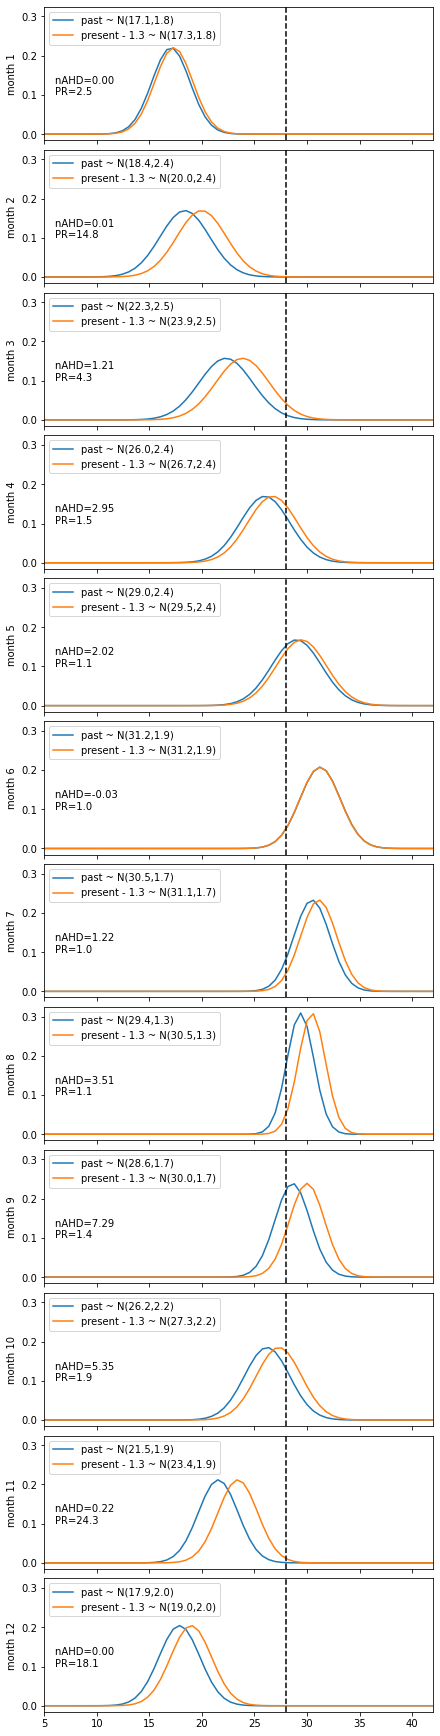

In [44]:
fig, axes = plt.subplots(12,1,figsize=(6,24),layout='constrained', sharex=True, sharey=True) 

gmst_pres = float(gmst_smo.loc[2022])
gmst_pi = float(gmst_pres - 1.3)

threshold=28

nAHD_sum = 0 

# loop over months 
for j in range(1,13):
    ax=axes[j-1]
    
    da = da_delhi.sel(time=da_delhi['time.month'].isin([j]))
    x = da.values
    t = da.time.dt.year 
    cov = gmst_smo.loc[t.values].values.squeeze()
    
    dist = distributions.norm_cov(data=x, cov=cov)
    b0,b1,sigma = dist.fit()
    
    norm_pi, norm_pres = norm(loc=b0+b1*gmst_pi, scale=sigma), norm(loc=b0+b1*gmst_pres, scale=sigma)

    xi = np.linspace (-10,50,100)

    ax.plot(xi, norm_pi.pdf(xi), label=f"past ~ N({norm_pi.kwds['loc']:.1f},{norm_pres.kwds['scale']:.1f})")
    ax.plot(xi, norm_pres.pdf(xi), label=f"present - 1.3 ~ N({norm_pres.kwds['loc']:.1f},{norm_pres.kwds['scale']:.1f})")
    
    nAHD=(norm_pres.sf(threshold)-norm_pi.sf(threshold))*30.5
    ax.text(6,0.1,f"nAHD={nAHD:.2f} \nPR={norm_pres.sf(threshold)/norm_pi.sf(threshold):.1f}")
    
    ax.set_xlim(5,42)
    ax.set_ylabel(f"month {j}")
    
    ax.axvline(28,ls='--',c='k')
    
    nAHD_sum = nAHD_sum + nAHD

    ax.legend()
    

In [45]:
print(nAHD_sum)

# 24 extra days per year with gmst smo 

# more or less the same as estimating from full yearly distr with shift fit

# test allowing scale to vary

# compare to empirical estimate and attrici-based estimate 

23.751660696087832


## TO DO ! 

- test allowing scale to vary (initially as linear fxn of GMST) - done, see below
- compare to empirical estimate from 2 time periods and obs and isimip3a attrici-based estimate of nAHD for these locations for agreement - see other notebook... do global/systematic comparison? 

Other possibilities / later
- similar to Gilford 2022, try a quantile-regression based method to construct a counterfactual?? for changes in tail if they arent well represented in this way.... 

## fit distcov on Delhi data: version 2. loc and scale both functions of GMST

### a) one model for full year

In [46]:
x = da_delhi.values

t = da_delhi.time.dt.year

cov = gmst_smo.loc[t.values].values.squeeze()

dist = distributions.norm_cov_std(data=x, cov=cov)

params_mle = dist.fit()

print(dist.param_names)
print(np.round(params_mle, 3))

['b0', 'b1', 'sigma_b0', 'sigma_b1']
[24.986  0.76   5.368 -0.199]


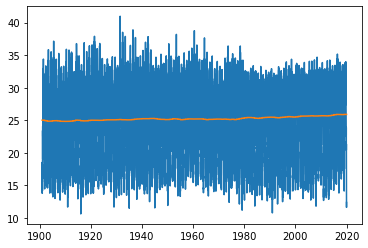

In [47]:
predicted = dist.predict(params_mle, cov)

# ===

f, ax = plt.subplots()

ax.plot(da_delhi.time, x)

ax.plot(da_delhi.time, predicted)

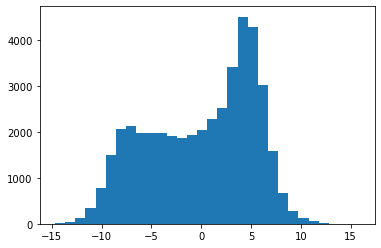

In [48]:
residuals = x - predicted
plt.hist(residuals,bins=30); # not normal at all 

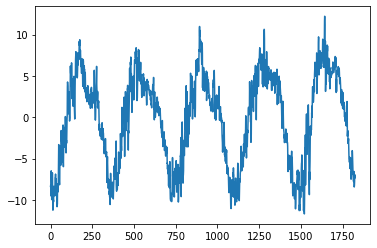

In [49]:
plt.plot(residuals[0:365*5 ]) # not normal, clear seasonality 

In [50]:
b0, b1, sigma_b0, sigma_b1 = params_mle

gmst_pres = float(gmst_smo.loc[2022])
gmst_pi = float(gmst_pres - 1.3) # PI as 2022 value minus 1.3 (GWI is 1.299)

# create theoretical distributions
norm_pi, norm_pres = norm(loc=b0+b1*gmst_pi, scale=sigma_b0+sigma_b1*gmst_pi), norm(loc=b0+b1*gmst_pres, scale=sigma_b0+sigma_b1*gmst_pres)

print(norm_pi.kwds['loc'], norm_pres.kwds['loc'],norm_pi.kwds['scale'], norm_pres.kwds['scale'])

24.860568402375236 25.848165348022288 5.4009755522974805 5.1425155432746426


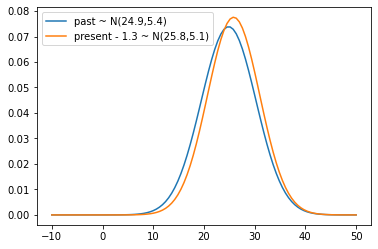

In [51]:
xi = np.linspace (-10,50,100)

plt.plot(xi, norm_pi.pdf(xi), label=f"past ~ N({norm_pi.kwds['loc']:.1f},{norm_pi.kwds['scale']:.1f})")
plt.plot(xi, norm_pres.pdf(xi), label=f"present - 1.3 ~ N({norm_pres.kwds['loc']:.1f},{norm_pres.kwds['scale']:.1f})")

plt.legend()

In [52]:
threshold = 28
PR = norm_pres.sf(threshold)/norm_pi.sf(threshold) 
nAHD = (norm_pres.sf(threshold) - norm_pi.sf(threshold) ) * 365 

print(f'PR:{PR:.3f}')
print(f'nAHD:{nAHD:.3f}')

# 21 extra days, less than without modifying scale 

PR:1.204
nAHD:20.909


### b) one model per month 

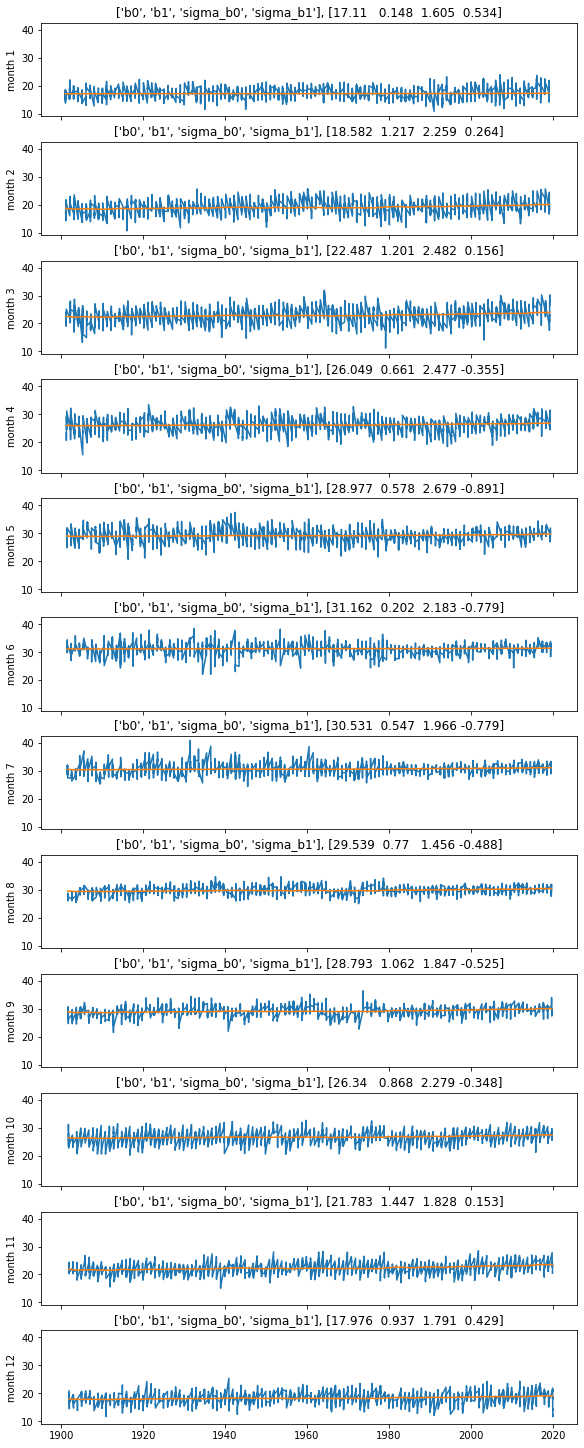

In [53]:
# monthly distribution shifting

fig, axes = plt.subplots(12,1,figsize=(8,20),layout='constrained', sharex=True, sharey=True)

arr_params = []

# loop over months 
for j in range(1,13):
    ax=axes[j-1]
    
    da = da_delhi.sel(time=da_delhi['time.month'].isin([j]))
    x = da.values
    t = da.time.dt.year 
    cov = gmst_smo.loc[t.values].values.squeeze()
    
    dist = distributions.norm_cov_std(data=x, cov=cov)
    params_mle = dist.fit()
    predicted = dist.predict(params_mle, cov)

    ax.plot(da.time, x)
    ax.plot(da.time, predicted)
    
    ax.set_title(f'{dist.param_names}, {np.round(params_mle, 3)}')
    ax.set_ylabel(f'month {j}')
    
    arr_params.append(params_mle)
    
arr_params = np.array(arr_params)

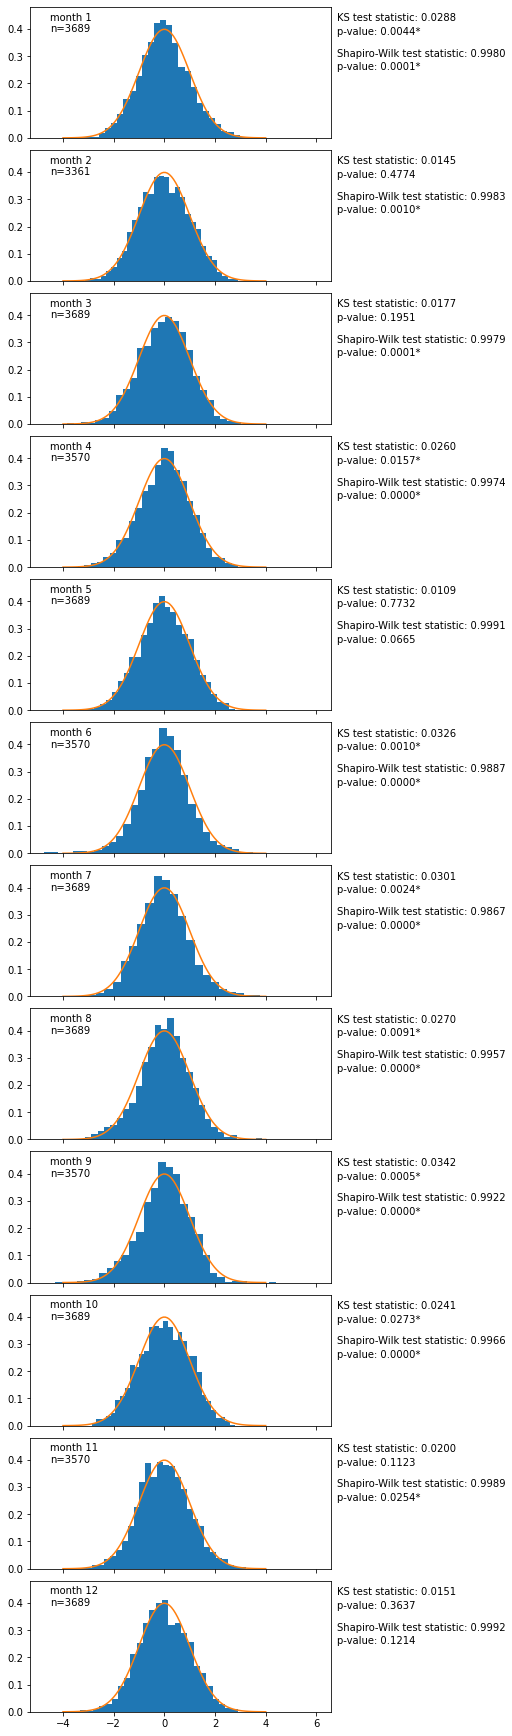

In [54]:

# do i need to standardize them to do these tests?

fig, axes = plt.subplots(12,1,figsize=(7,24),layout='constrained', sharex=True, sharey=True) # figsize 5, 30 for non standardized residuals 

norm_standard = norm(loc=0, scale=1)

# loop over months 
for j in range(1,13):
    ax=axes[j-1]
    
    da = da_delhi.sel(time=da_delhi['time.month'].isin([j]))
    x = da.values
    t = da.time.dt.year 
    cov = gmst_smo.loc[t.values].values.squeeze()
    
    dist = distributions.norm_cov_std(data=x, cov=cov)
    params_mle = dist.fit()
    predicted = dist.predict(params_mle, cov)
    
    residuals = x - predicted
    
    # plot raw residuals
    #ax.hist(residuals,bins=30,density=True); 
    
    # plot standardixed residuals 
    standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
    ax.hist(standardized_residuals,bins=30,density=True); # not normal at all 
    
    # plot theoretical distr
    xi=np.linspace(-4,4,100)
    ax.plot(xi,norm_standard.pdf(xi))
    
    ax.text(-4.5,0.39,f'month {j}\nn={len(standardized_residuals)}')

    
    # Kolmogorov-Smirnov Test: test 
    # H0: standard normal, Ha: not standard normal (p-value < significance)
    D, p_value = kstest(standardized_residuals, 'norm')
    ax.text(6.8,0.43,f"KS test statistic: {D:.4f}")  # -12,0.3 for non standardized
    if p_value < 0.05:
        ax.text(6.8,0.38,f"p-value: {p_value:.4f}*") # not normally distributed
    else:
        ax.text(6.8,0.38,f"p-value: {p_value:.4f}") # -12,0.25 for non standardized 
        
    #Shapiro-Wilk
    stat, p_value = shapiro(standardized_residuals)

    pos = 0.30
    ax.text(6.8,pos,f"Shapiro-Wilk test statistic: {stat:.4f}")  # -12,0.3 for non standardized
    if p_value < 0.05:
        ax.text(6.8,pos-.05,f"p-value: {p_value:.4f}*") # not normally distributed
    else:
        ax.text(6.8,pos-.05,f"p-value: {p_value:.4f}") # -12,0.25 for non standardized 

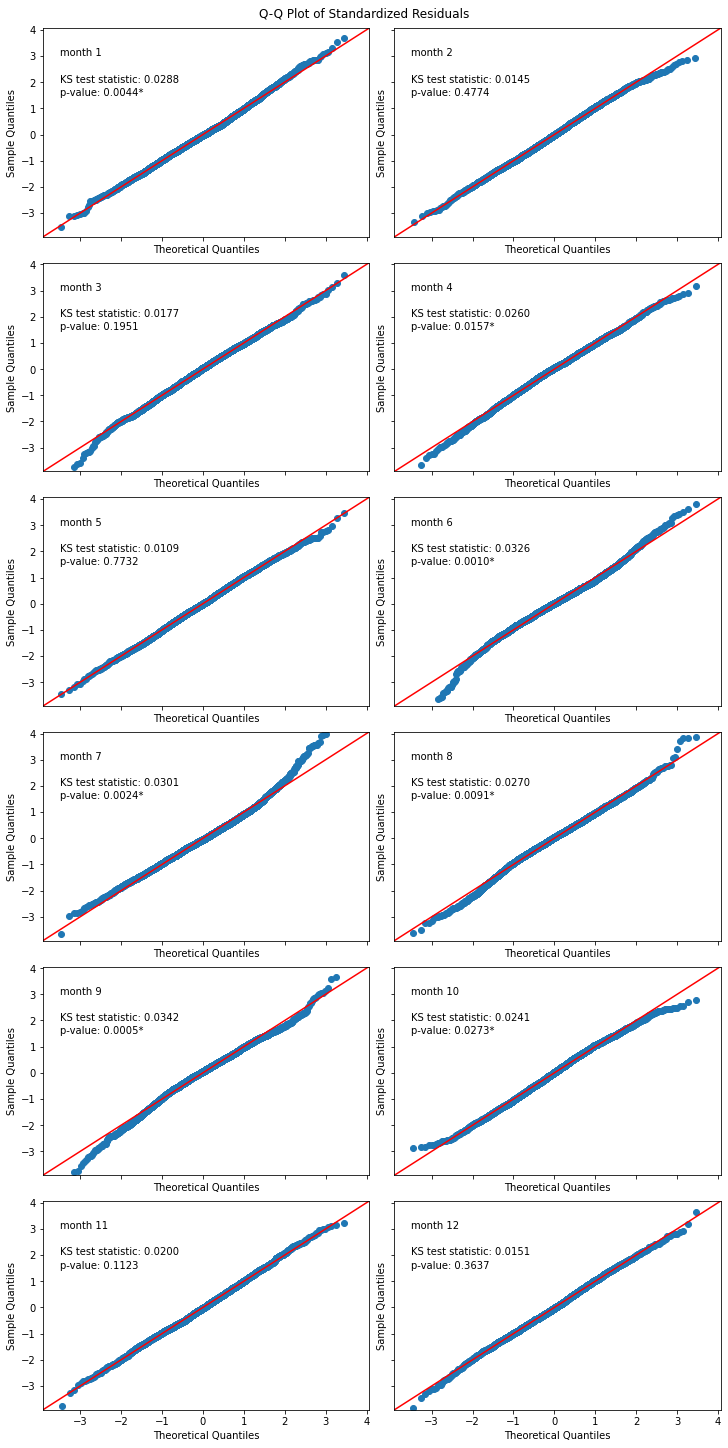

In [55]:
fig, axes = plt.subplots(6,2,figsize=(10,20),layout='constrained', sharex=True, sharey=True) 


# loop over months 
for j in range(1,13):
    ax=axes.flatten()[j-1]
    
    da = da_delhi.sel(time=da_delhi['time.month'].isin([j]))
    x = da.values
    t = da.time.dt.year 
    cov = gmst_smo.loc[t.values].values.squeeze()
    
    dist = distributions.norm_cov_std(data=x, cov=cov)
    params_mle = dist.fit()
    predicted = dist.predict(params_mle, cov)
    
    residuals = x - predicted
    
    # plot standardixed residuals 
    standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
    
    # Q-Q Plot
    sm.qqplot(standardized_residuals, line ='45',ax=ax)
    ax.text(-3.5,3,f'month {j}')
    
    # KS test H0: standard normal, Ha: not standard normal (p-value < significance)
    D, p_value = kstest(standardized_residuals, 'norm')
    ax.text(-3.5,2,f"KS test statistic: {D:.4f}")  
    if p_value < 0.05:
        ax.text(-3.5,1.5,f"p-value: {p_value:.4f}*") # not normally distributed
    else:
        ax.text(-3.5,1.5,f"p-value: {p_value:.4f}") 

fig.suptitle("Q-Q Plot of Standardized Residuals");

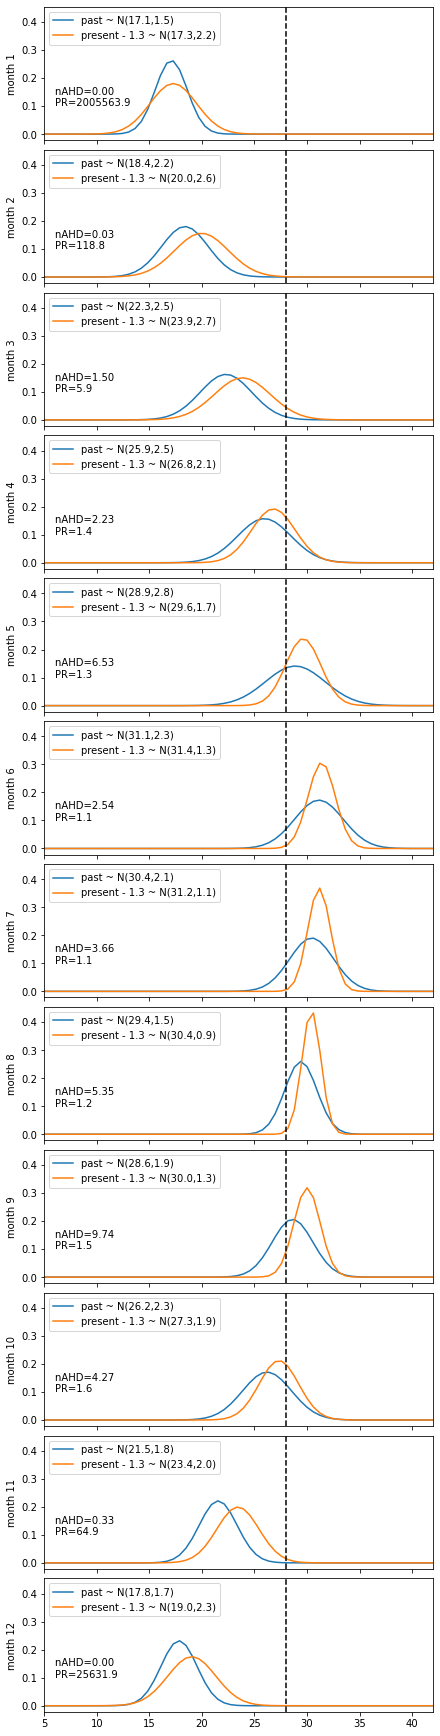

In [56]:
fig, axes = plt.subplots(12,1,figsize=(6,24),layout='constrained', sharex=True, sharey=True) 

gmst_pres = float(gmst_smo.loc[2022])
gmst_pi = float(gmst_pres - 1.3)

threshold=28

nAHD_sum = 0 

# loop over months 
for j in range(1,13):
    ax=axes[j-1]
    
    da = da_delhi.sel(time=da_delhi['time.month'].isin([j]))
    x = da.values
    t = da.time.dt.year 
    cov = gmst_smo.loc[t.values].values.squeeze()
    
    dist = distributions.norm_cov_std(data=x, cov=cov)
    b0,b1,sigma_b0, sigma_b1 = dist.fit()
    
    norm_pi, norm_pres = norm(loc=b0+b1*gmst_pi, scale=sigma_b0+sigma_b1*gmst_pi), norm(loc=b0+b1*gmst_pres, scale=sigma_b0+sigma_b1*gmst_pres)

    xi = np.linspace (-10,50,100)

    ax.plot(xi, norm_pi.pdf(xi), label=f"past ~ N({norm_pi.kwds['loc']:.1f},{norm_pi.kwds['scale']:.1f})")
    ax.plot(xi, norm_pres.pdf(xi), label=f"present - 1.3 ~ N({norm_pres.kwds['loc']:.1f},{norm_pres.kwds['scale']:.1f})")
    
    nAHD=(norm_pres.sf(threshold)-norm_pi.sf(threshold))*30.5
    ax.text(6,0.1,f"nAHD={nAHD:.2f} \nPR={norm_pres.sf(threshold)/norm_pi.sf(threshold):.1f}")
    
    ax.set_xlim(5,42)
    ax.set_ylabel(f"month {j}")
    
    ax.axvline(28,ls='--',c='k')
    
    nAHD_sum = nAHD_sum + nAHD

    ax.legend()

In [57]:
print(nAHD_sum)

# more or less agrees with comparison of 2 periods obsclim 20 year periods

36.188379526607626


## fit distcov on Calcutta data: one model for full year

### a) loc only varies



In [58]:
x = da_calcutta.values

t = da_calcutta.time.dt.year

cov = gmst_smo.loc[t.values].values.squeeze()

dist = distributions.norm_cov(data=x, cov=cov)

params_mle = dist.fit()

print(dist.param_names)
print(np.round(params_mle, 3))

['b0', 'b1', 'sigma']
[26.384  1.063  3.859]


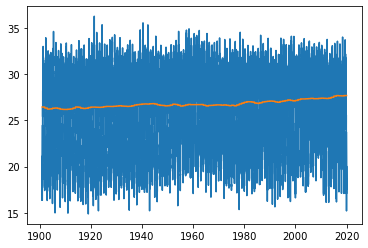

In [59]:
predicted = dist.predict(params_mle, cov)

# ===

f, ax = plt.subplots()

ax.plot(da_calcutta.time, x)

ax.plot(da_calcutta.time, predicted)

In [60]:
b0, b1, sigma = params_mle

gmst_pres = float(gmst_smo.loc[2022])
gmst_pi = float(gmst_pres - 1.3) # PI as 2022 value minus 1.3 (GWI is 1.299)

# create theoretical distributions
norm_pi, norm_pres = norm(loc=b0+b1*gmst_pi, scale=sigma), norm(loc=b0+b1*gmst_pres, scale=sigma)

print(norm_pi.kwds['loc'], norm_pres.kwds['loc'],norm_pi.kwds['scale'], norm_pres.kwds['scale'])

26.20881940499452 27.59092881699402 3.858839662561614 3.858839662561614


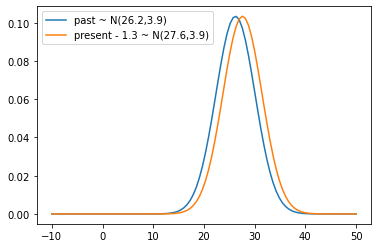

In [61]:
xi = np.linspace (-10,50,100)

plt.plot(xi, norm_pi.pdf(xi), label=f"past ~ N({norm_pi.kwds['loc']:.1f},{norm_pi.kwds['scale']:.1f})")
plt.plot(xi, norm_pres.pdf(xi), label=f"present - 1.3 ~ N({norm_pres.kwds['loc']:.1f},{norm_pres.kwds['scale']:.1f})")

plt.legend()

In [62]:
threshold = 28
PR = norm_pres.sf(threshold)/norm_pi.sf(threshold) 
nAHD = (norm_pres.sf(threshold) - norm_pi.sf(threshold) ) * 365 

print(f'PR:{PR:.3f}')
print(f'nAHD:{nAHD:.3f}')

# 49 extra days, similar change with and without including scale 

PR:1.425
nAHD:49.832


### b) loc and scale vary

In [63]:
x = da_calcutta.values

t = da_calcutta.time.dt.year

cov = gmst_smo.loc[t.values].values.squeeze()

dist = distributions.norm_cov_std(data=x, cov=cov)

params_mle = dist.fit()

print(dist.param_names)
print(np.round(params_mle, 3))

['b0', 'b1', 'sigma_b0', 'sigma_b1']
[26.394  1.036  3.98  -0.342]


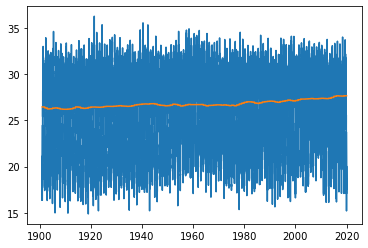

In [64]:
predicted = dist.predict(params_mle, cov)

# ===

f, ax = plt.subplots()

ax.plot(da_calcutta.time, x)

ax.plot(da_calcutta.time, predicted)

In [65]:
b0, b1, sigma_b0, sigma_b1 = params_mle

gmst_pres = float(gmst_smo.loc[2022])
gmst_pi = float(gmst_pres - 1.3) # PI as 2022 value minus 1.3 (GWI is 1.299)

# create theoretical distributions
norm_pi, norm_pres = norm(loc=b0+b1*gmst_pi, scale=sigma_b0+sigma_b1*gmst_pi), norm(loc=b0+b1*gmst_pres, scale=sigma_b0+sigma_b1*gmst_pres)

print(norm_pi.kwds['loc'], norm_pres.kwds['loc'],norm_pi.kwds['scale'], norm_pres.kwds['scale'])

26.223064029239005 27.570253408563946 4.0363784182270885 3.5914308896221514


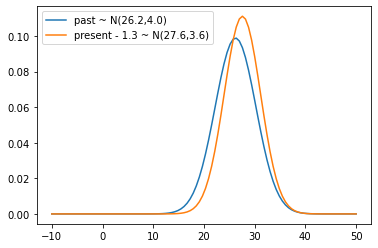

In [66]:
xi = np.linspace (-10,50,100)

plt.plot(xi, norm_pi.pdf(xi), label=f"past ~ N({norm_pi.kwds['loc']:.1f},{norm_pi.kwds['scale']:.1f})")
plt.plot(xi, norm_pres.pdf(xi), label=f"present - 1.3 ~ N({norm_pres.kwds['loc']:.1f},{norm_pres.kwds['scale']:.1f})")

plt.legend()

In [67]:
threshold = 28
PR = norm_pres.sf(threshold)/norm_pi.sf(threshold) 
nAHD = (norm_pres.sf(threshold) - norm_pi.sf(threshold) ) * 365 

print(f'PR:{PR:.3f}')
print(f'nAHD:{nAHD:.3f}')

# 45 extra days 

PR:1.371
nAHD:44.709


## fit distcov on Calcutta: one model per month

### a) loc only varies

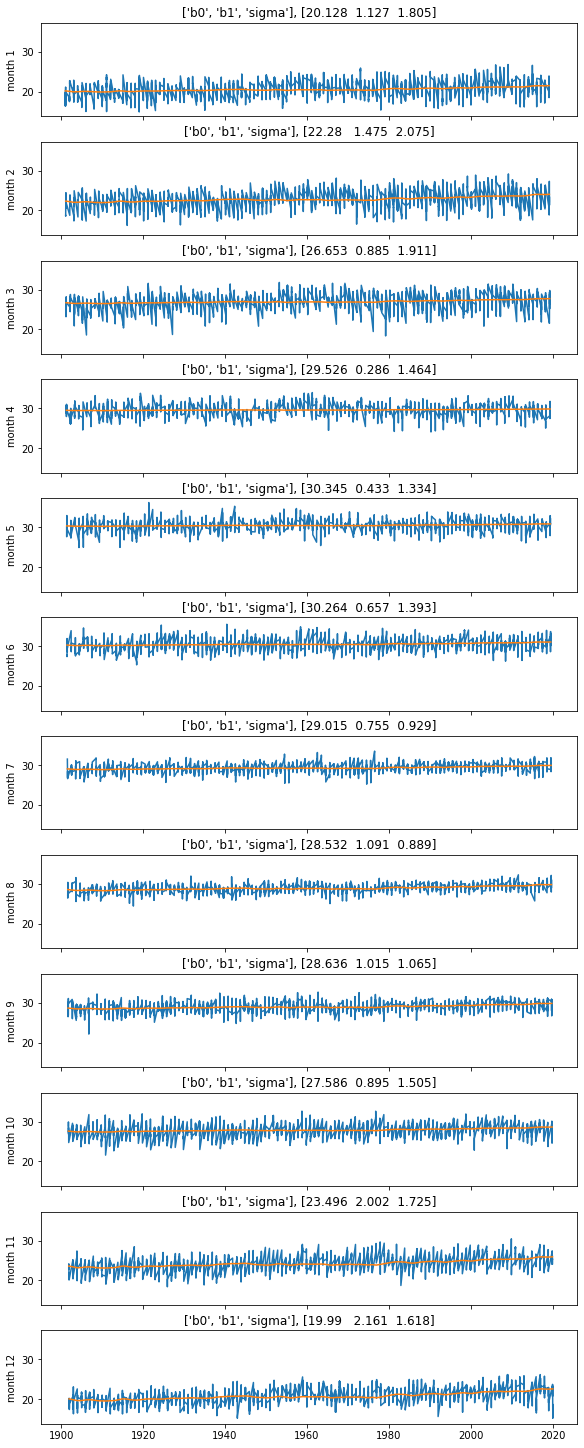

In [68]:
# monthly distribution shifting

fig, axes = plt.subplots(12,1,figsize=(8,20),layout='constrained', sharex=True, sharey=True)

arr_params = []

# loop over months 
for j in range(1,13):
    ax=axes[j-1]
    
    da = da_calcutta.sel(time=da_calcutta['time.month'].isin([j]))
    x = da.values
    t = da.time.dt.year 
    cov = gmst_smo.loc[t.values].values.squeeze()
    
    dist = distributions.norm_cov(data=x, cov=cov)
    params_mle = dist.fit()
    predicted = dist.predict(params_mle, cov)

    ax.plot(da.time, x)
    ax.plot(da.time, predicted)
    
    ax.set_title(f'{dist.param_names}, {np.round(params_mle, 3)}')
    ax.set_ylabel(f'month {j}')

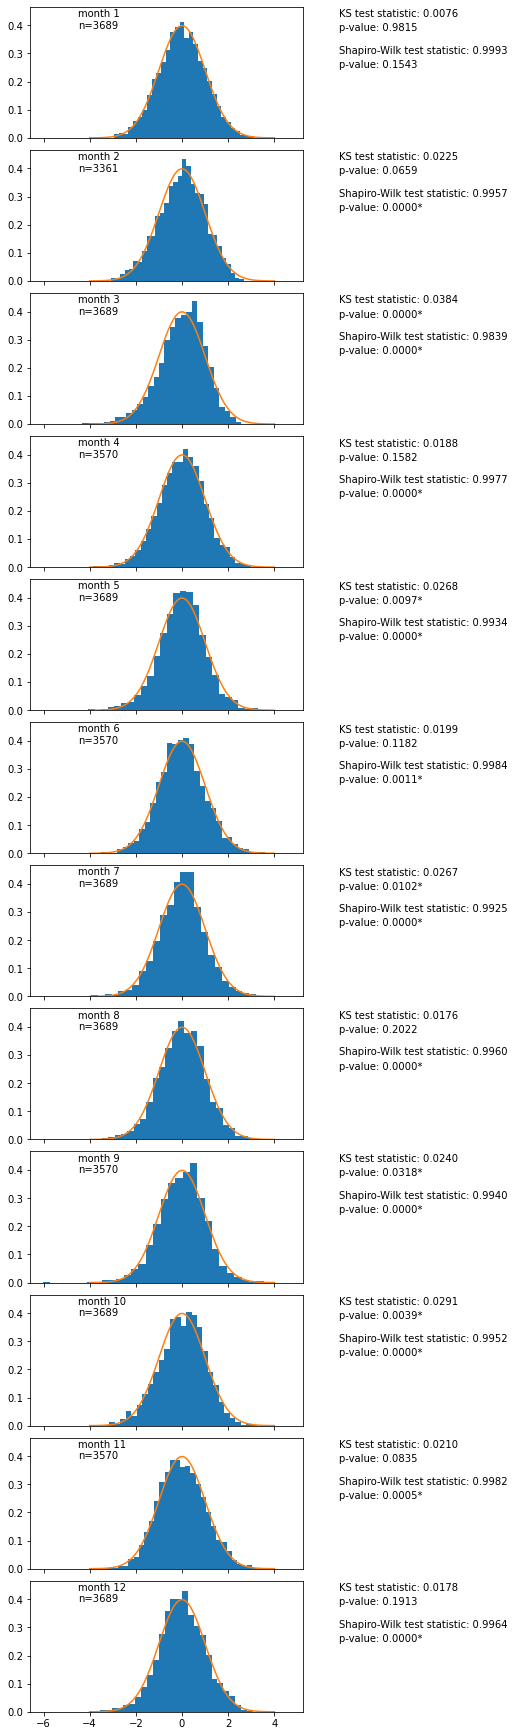

In [69]:
fig, axes = plt.subplots(12,1,figsize=(7,24),layout='constrained', sharex=True, sharey=True) # figsize 5, 30 for non standardized residuals 

norm_standard = norm(loc=0, scale=1)

# loop over months 
for j in range(1,13):
    ax=axes[j-1]
    
    da = da_calcutta.sel(time=da_calcutta['time.month'].isin([j]))
    x = da.values
    t = da.time.dt.year 
    cov = gmst_smo.loc[t.values].values.squeeze()
    
    dist = distributions.norm_cov(data=x, cov=cov)
    params_mle = dist.fit()
    predicted = dist.predict(params_mle, cov)
    
    residuals = x - predicted
    
    # plot standardixed residuals 
    standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
    ax.hist(standardized_residuals,bins=30,density=True); # not normal at all 
    
    # plot theoretical distr
    xi=np.linspace(-4,4,100)
    ax.plot(xi,norm_standard.pdf(xi))
    
    ax.text(-4.5,0.39,f'month {j}\nn={len(standardized_residuals)}')

    
    # Kolmogorov-Smirnov Test: test 
    # H0: standard normal, Ha: not standard normal (p-value < significance)
    D, p_value = kstest(standardized_residuals, 'norm')
    ax.text(6.8,0.43,f"KS test statistic: {D:.4f}")  # -12,0.3 for non standardized
    if p_value < 0.05:
        ax.text(6.8,0.38,f"p-value: {p_value:.4f}*") # not normally distributed
    else:
        ax.text(6.8,0.38,f"p-value: {p_value:.4f}") # -12,0.25 for non standardized 
        
    #Shapiro-Wilk
    stat, p_value = shapiro(standardized_residuals)

    pos = 0.30
    ax.text(6.8,pos,f"Shapiro-Wilk test statistic: {stat:.4f}")  # -12,0.3 for non standardized
    if p_value < 0.05:
        ax.text(6.8,pos-.05,f"p-value: {p_value:.4f}*") # not normally distributed
    else:
        ax.text(6.8,pos-.05,f"p-value: {p_value:.4f}") # -12,0.25 for non standardized 


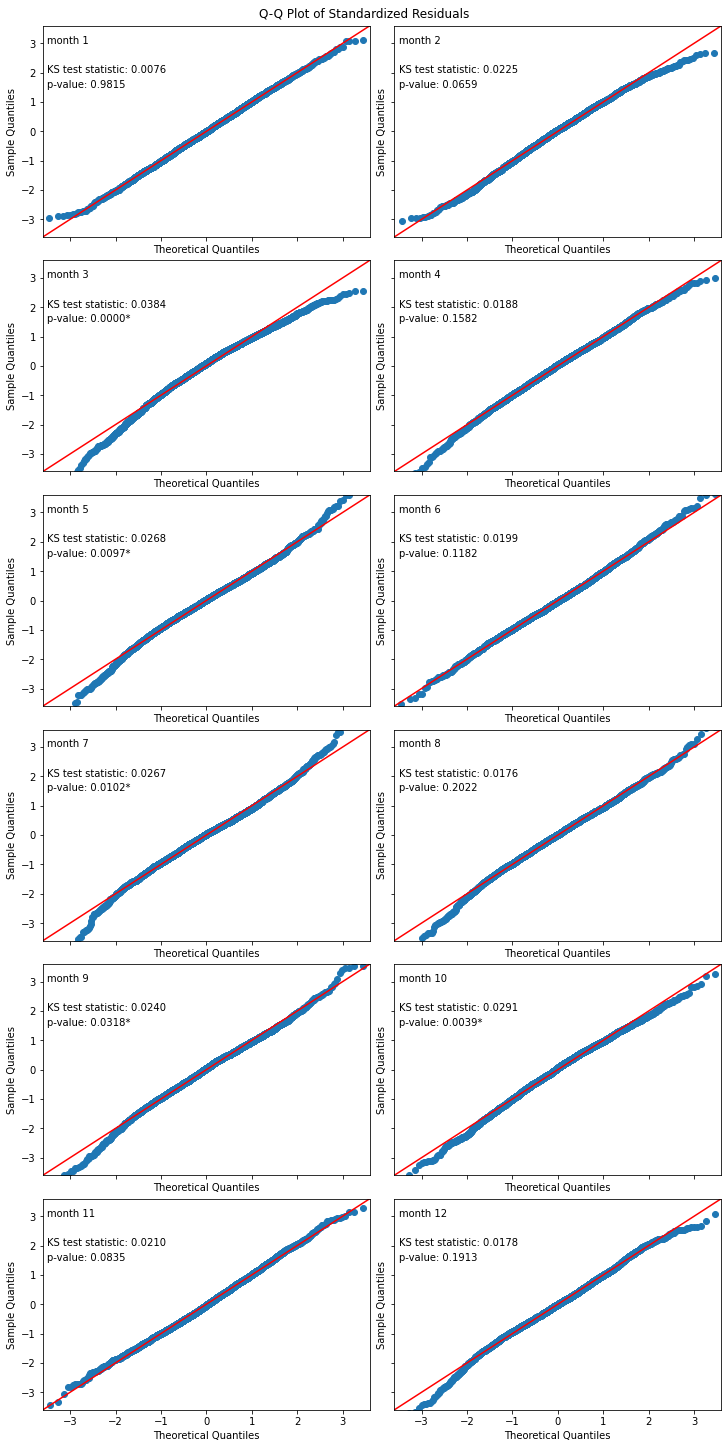

In [70]:
fig, axes = plt.subplots(6,2,figsize=(10,20),layout='constrained', sharex=True, sharey=True) 


# loop over months 
for j in range(1,13):
    ax=axes.flatten()[j-1]
    
    da = da_calcutta.sel(time=da_calcutta['time.month'].isin([j]))
    x = da.values
    t = da.time.dt.year 
    cov = gmst_smo.loc[t.values].values.squeeze()
    
    dist = distributions.norm_cov(data=x, cov=cov)
    params_mle = dist.fit()
    predicted = dist.predict(params_mle, cov)
    
    residuals = x - predicted
    
    # plot standardixed residuals 
    standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
    
    # Q-Q Plot
    sm.qqplot(standardized_residuals, line ='45',ax=ax)
    ax.text(-3.5,3,f'month {j}')
    
    # KS test H0: standard normal, Ha: not standard normal (p-value < significance)
    D, p_value = kstest(standardized_residuals, 'norm')
    ax.text(-3.5,2,f"KS test statistic: {D:.4f}")  
    if p_value < 0.05:
        ax.text(-3.5,1.5,f"p-value: {p_value:.4f}*") # not normally distributed
    else:
        ax.text(-3.5,1.5,f"p-value: {p_value:.4f}") 

fig.suptitle("Q-Q Plot of Standardized Residuals");

# some are left skewed

# understand what this means re the bias in my model ! 

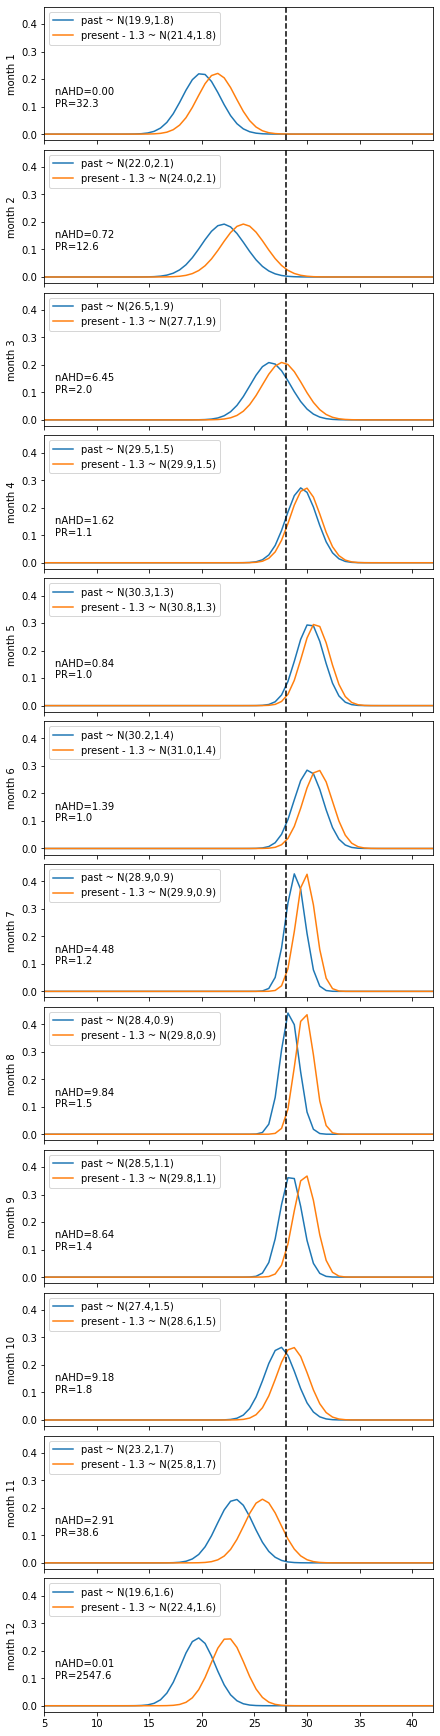

In [71]:
fig, axes = plt.subplots(12,1,figsize=(6,24),layout='constrained', sharex=True, sharey=True) 

gmst_pres = float(gmst_smo.loc[2022])
gmst_pi = float(gmst_pres - 1.3)

threshold=28

nAHD_sum = 0 

# loop over months 
for j in range(1,13):
    ax=axes[j-1]
    
    da = da_calcutta.sel(time=da_calcutta['time.month'].isin([j]))
    x = da.values
    t = da.time.dt.year 
    cov = gmst_smo.loc[t.values].values.squeeze()
    
    dist = distributions.norm_cov(data=x, cov=cov)
    b0,b1,sigma = dist.fit()
    
    norm_pi, norm_pres = norm(loc=b0+b1*gmst_pi, scale=sigma), norm(loc=b0+b1*gmst_pres, scale=sigma)

    xi = np.linspace (-10,50,100)

    ax.plot(xi, norm_pi.pdf(xi), label=f"past ~ N({norm_pi.kwds['loc']:.1f},{norm_pres.kwds['scale']:.1f})")
    ax.plot(xi, norm_pres.pdf(xi), label=f"present - 1.3 ~ N({norm_pres.kwds['loc']:.1f},{norm_pres.kwds['scale']:.1f})")
    
    nAHD=(norm_pres.sf(threshold)-norm_pi.sf(threshold))*30.5
    ax.text(6,0.1,f"nAHD={nAHD:.2f} \nPR={norm_pres.sf(threshold)/norm_pi.sf(threshold):.1f}")
    
    ax.set_xlim(5,42)
    ax.set_ylabel(f"month {j}")
    
    ax.axvline(28,ls='--',c='k')
    
    nAHD_sum = nAHD_sum + nAHD

    ax.legend()

In [72]:
print(nAHD_sum)

# 46 extra days 

46.08393949925855


### b) loc and scale vary

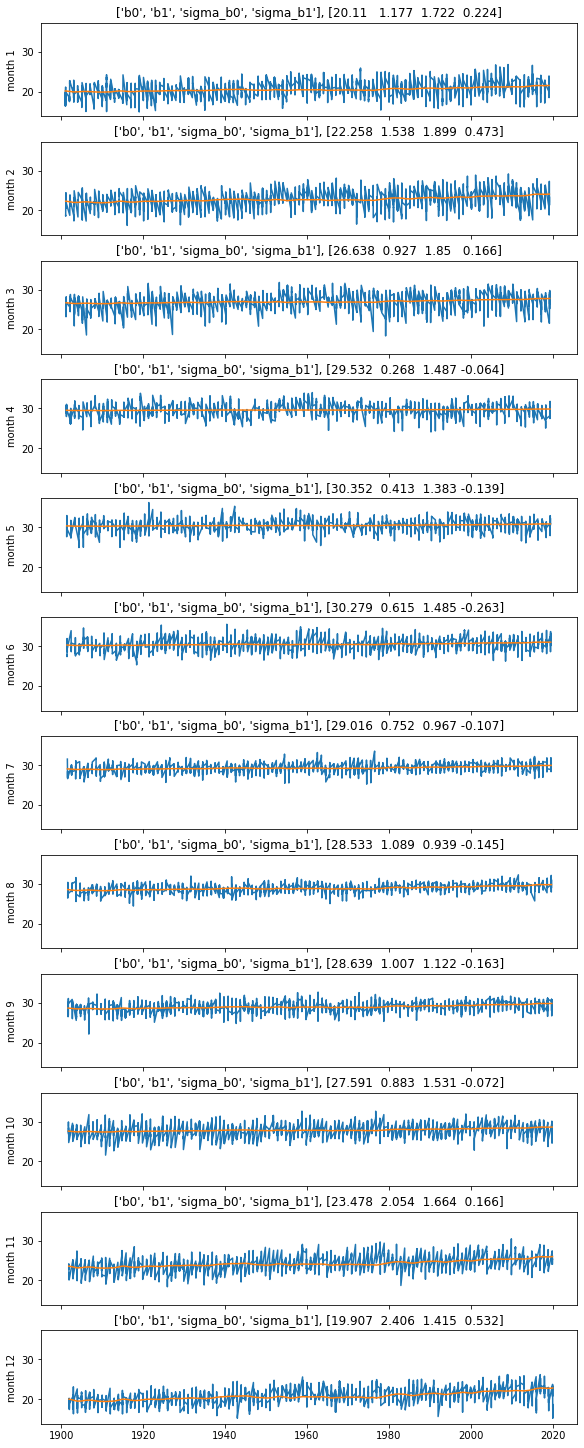

In [73]:
fig, axes = plt.subplots(12,1,figsize=(8,20),layout='constrained', sharex=True, sharey=True)

arr_params = []

# loop over months 
for j in range(1,13):
    ax=axes[j-1]
    
    da = da_calcutta.sel(time=da_calcutta['time.month'].isin([j]))
    x = da.values
    t = da.time.dt.year 
    cov = gmst_smo.loc[t.values].values.squeeze()
    
    dist = distributions.norm_cov_std(data=x, cov=cov)
    params_mle = dist.fit()
    predicted = dist.predict(params_mle, cov)

    ax.plot(da.time, x)
    ax.plot(da.time, predicted)
    
    ax.set_title(f'{dist.param_names}, {np.round(params_mle, 3)}')
    ax.set_ylabel(f'month {j}')

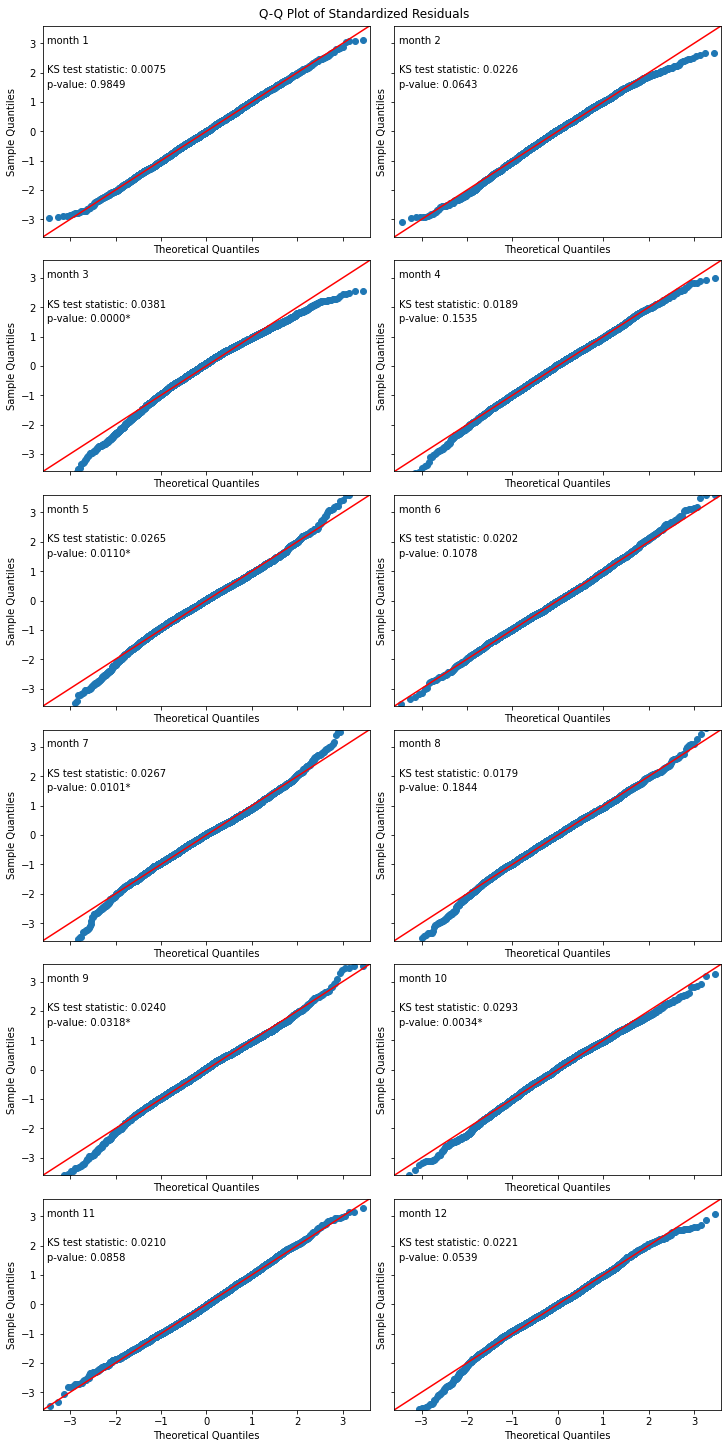

In [74]:
fig, axes = plt.subplots(6,2,figsize=(10,20),layout='constrained', sharex=True, sharey=True) 


# loop over months 
for j in range(1,13):
    ax=axes.flatten()[j-1]
    
    da = da_calcutta.sel(time=da_calcutta['time.month'].isin([j]))
    x = da.values
    t = da.time.dt.year 
    cov = gmst_smo.loc[t.values].values.squeeze()
    
    dist = distributions.norm_cov_std(data=x, cov=cov)
    params_mle = dist.fit()
    predicted = dist.predict(params_mle, cov)
    
    residuals = x - predicted
    
    # plot standardixed residuals 
    standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
    
    # Q-Q Plot
    sm.qqplot(standardized_residuals, line ='45',ax=ax)
    ax.text(-3.5,3,f'month {j}')
    
    # KS test H0: standard normal, Ha: not standard normal (p-value < significance)
    D, p_value = kstest(standardized_residuals, 'norm')
    ax.text(-3.5,2,f"KS test statistic: {D:.4f}")  
    if p_value < 0.05:
        ax.text(-3.5,1.5,f"p-value: {p_value:.4f}*") # not normally distributed
    else:
        ax.text(-3.5,1.5,f"p-value: {p_value:.4f}") 

fig.suptitle("Q-Q Plot of Standardized Residuals");

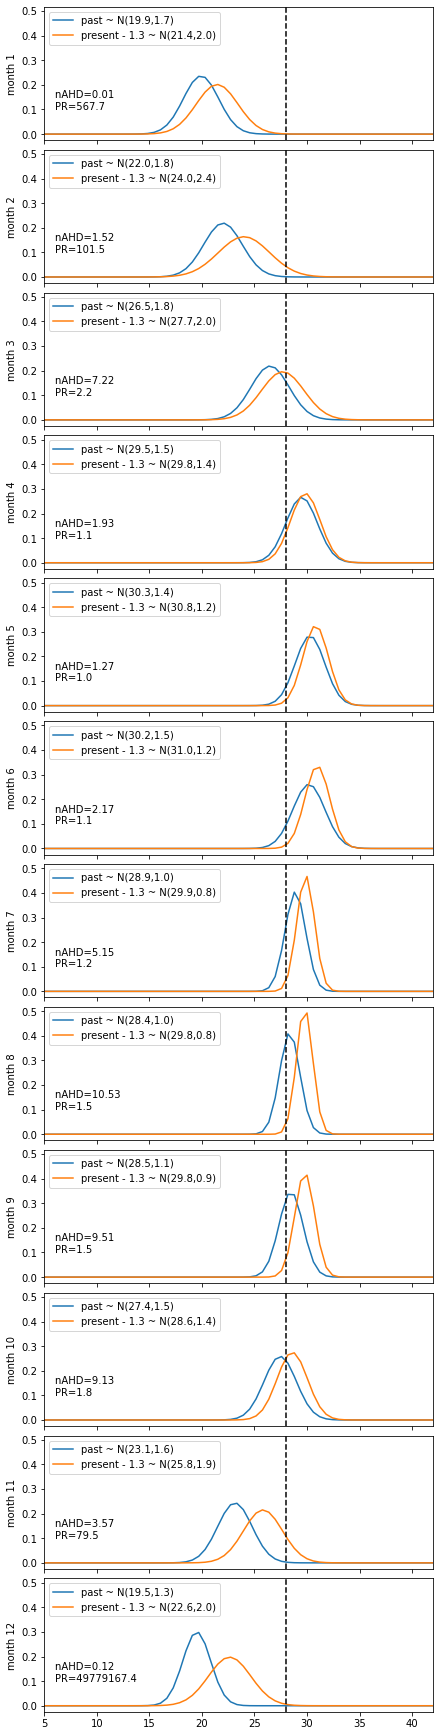

In [75]:
fig, axes = plt.subplots(12,1,figsize=(6,24),layout='constrained', sharex=True, sharey=True) 

gmst_pres = float(gmst_smo.loc[2022])
gmst_pi = float(gmst_pres - 1.3)

threshold=28

nAHD_sum = 0 

# loop over months 
for j in range(1,13):
    ax=axes[j-1]
    
    da = da_calcutta.sel(time=da_calcutta['time.month'].isin([j]))
    x = da.values
    t = da.time.dt.year 
    cov = gmst_smo.loc[t.values].values.squeeze()
    
    dist = distributions.norm_cov_std(data=x, cov=cov)
    b0,b1,sigma_b0, sigma_b1 = dist.fit()
    
    norm_pi, norm_pres = norm(loc=b0+b1*gmst_pi, scale=sigma_b0+sigma_b1*gmst_pi), norm(loc=b0+b1*gmst_pres, scale=sigma_b0+sigma_b1*gmst_pres)

    xi = np.linspace (-10,50,100)

    ax.plot(xi, norm_pi.pdf(xi), label=f"past ~ N({norm_pi.kwds['loc']:.1f},{norm_pi.kwds['scale']:.1f})")
    ax.plot(xi, norm_pres.pdf(xi), label=f"present - 1.3 ~ N({norm_pres.kwds['loc']:.1f},{norm_pres.kwds['scale']:.1f})")
    
    nAHD=(norm_pres.sf(threshold)-norm_pi.sf(threshold))*30.5
    ax.text(6,0.1,f"nAHD={nAHD:.2f} \nPR={norm_pres.sf(threshold)/norm_pi.sf(threshold):.1f}")
    
    ax.set_xlim(5,42)
    ax.set_ylabel(f"month {j}")
    
    ax.axvline(28,ls='--',c='k')
    
    nAHD_sum = nAHD_sum + nAHD

    ax.legend()

In [76]:
print(nAHD_sum)

# 52 extra days 

52.13121462342998
